<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 5: Practical - Recurrent Neural Networks <br>
<font color=696880 size=4>
    Alireza Farashah, Parsa Hosseini
    
    
____


### Full Name : Amir Hossein Rahmati
### Student Number : 
___

# Image Captioning using Recurrent Neural Networks
In this notebook we want to implement a deep neural network to caption Flickr images. It has 8091 images and each image in this dataset has an ID and there are 5 caption for each image in captions.txt file which is uploaded in Quera. We use pretrained ResNet50 model to get meaningful features from each image. Code of this part is implemented and you have to use id_to_feature and id_to_caption dictionary. See the code to understand what are these two dictionaries.
You have to implement the empty parts of this notebook.

# Import Libaries and Dataset

In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [ ]:
!unzip /content/Flickr8k_Dataset.zip -d /content/images/

In [4]:
!unzip /content/captions.txt.zip -d /content/text/

Archive:  /content/captions.txt.zip
  inflating: /content/text/captions.txt  


# Creeating Features and Captions Dcitionary

In [5]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    pooling='avg'
)

94765736/94765736 [==============================] - 5s 0us/step


In [6]:
id_to_features = {}

for name in tqdm(os.listdir("/content/images/Flicker8k_Dataset")):
    img = img_to_array(load_img("/content/images/Flicker8k_Dataset/" + name, target_size=(224,224)))
    img = preprocess_input(img.reshape((1, img.shape[0], img.shape[1], img.shape[2])))
    feature = resnet50.predict(img, verbose=0)
    id_to_features[name.split('.')[0]]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [7]:
id_to_features['587604325_af5d6df679'].shape

(1, 2048)

In [8]:
len(id_to_features)

8091

In [9]:
from itertools import islice

id_to_captions = {}

with open("/content/text/captions.txt", 'r') as f:
    for i, line in enumerate(f):
        if i==0:
            continue
        tokens = line.split('.jpg,')
        id, caption = tokens[0], tokens[1]
        if id not in id_to_captions:
            id_to_captions[id] = []
        id_to_captions[id].append(caption) 

In [10]:
len(id_to_captions)

8091

In [11]:
id_to_captions['587604325_af5d6df679']

['A curly haired dog tries to bite another dog wearing a green and orange collar .\n',
 'One brown dog is bearing its teeth at another brown dog with a green collar in a park .\n',
 'Two brown dogs playing .\n',
 '"Two dogs , one with its mouth open ."\n',
 'Two golden dogs playing with one another\n']

# Preprocessing and Tokenizing (15 points)

In this part you need to clean the captions text in order to use Tokenizer.

In [12]:
# preprocess caption texts
import re
def preprocessing():
    for id, captions in id_to_captions.items():
        for i, caption in enumerate(captions):
            caption = caption.replace('\t', '').replace('\n', '').lower()      
            caption = re.sub(r"[^a-z0-9]+", " ", caption)
            caption = 'start_char ' + caption + ' end_char'
            captions[i] = caption
        
preprocessing()

In [13]:
all_captions = []
for id, captions in id_to_captions.items():
    for caption in captions:
        all_captions.append(caption)

len(all_captions)

40455

In [14]:
# Tokenize captions
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(all_captions )
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# Find the maximum length of any caption in our dataset
max_length = max(len(caption.split()) for caption in captions)
print('caption Length: %d' % max_length)
max_length = max_length + 20


Vocabulary Size: 8491
caption Length: 17


## Data Generator (25 points)

In this part implement a data generator function to use during the training.
For each image and caption you have to create number of train samples in the following format.

caption: "start_char the man is playing football end_char"

sample 0: X="start_char", Y="the "

sample 1: X="start_char the", Y="man"

...

sample n: X="start_char the man is playing football", Y="end_char"

In [15]:
# craete data generator 
def data_generator():
    sequence = []
    features = []
    target = []
    n = 0
    while True:
        for id, captions in id_to_captions.items():
            for caption in captions:
                n += 1
                # tokenize the caption
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad sequences
                    in_seq = pad_sequences([in_seq], max_length , padding='post')[0]
                    # one hot encode of output sequence
                    out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]

                    sequence.append(in_seq)
                    target.append(out_seq)
                    features.append(id_to_features[id][0])
                
                yield [[np.array(features), np.array(sequence)], np.array(target)]
                sequence = []
                features = []
                target = []
                n = 0

## Model (20 points)

In [16]:
# i got some help from "https://blog.paperspace.com/image-captioning-with-tensorflow/" in this part

# define the model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Concatenate, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# images input layer
inputs_img = Input(shape=(2048,))
drop1 = Dropout(0.5)(inputs_img)
linear1 = Dense(256, activation='relu')(drop1)
drop2 = Dropout(0.5)(inputs_img)
linear2 = Dense(256, activation='relu')(drop2)



# captions input layer
inputs_cap = Input(shape=(max_length,))
embed = Embedding(vocab_size, 128 , mask_zero=True)(inputs_cap)
lstm = LSTM(128)(embed)


# merge input layers
merge1 = Concatenate()([linear2, lstm])
dense = Dense(128, activation='relu')(merge1)
outputs = Dense(vocab_size, activation='softmax')(dense)

# define the model
model = Model(inputs=[inputs_img, inputs_cap], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



# Train (10 points)

Train the model and plot loss for training data.

In [17]:
# train the model
epochs = 35
number_pics_per_bath = 5
steps = len(id_to_captions)//number_pics_per_bath
train_losses = []
train_accs = []
for i in range(epochs):
    generator = data_generator()
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')
    train_losses.append(model.history.history['loss'])
    train_accs.append(model.history.history['accuracy'])
    

<ipython-input-17-836342aaa204>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


1618/1618 [==============================] - 16s 10ms/step - loss: 0.8522 - accuracy: 0.7488


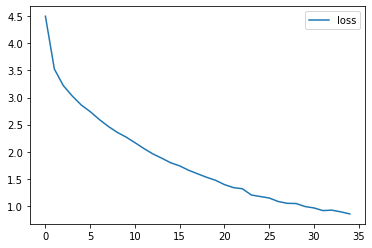

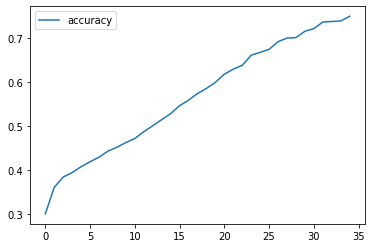

In [18]:
# plot the training loss and accuracy
import matplotlib.pyplot as plt
plt.plot(train_losses,label='loss')
plt.legend()
plt.show()
plt.plot(train_accs,label='accuracy')
plt.legend()
plt.show()


## Test (30)

In this part evaluate the model and generate caption for 10 of test images. For evaluation use "bert-base-uncased" pretrained model and calculate similarity for the predicted sentence of model and real captions. 
Show 3 of the images and predictied samples.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


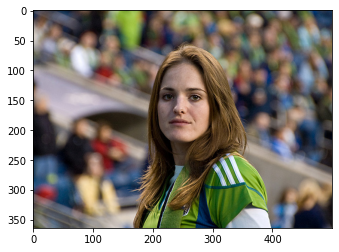

predicted caption : a few girls with green foam statue of liberty hats on the cheek
most similar caption : woman with brown hair and brown eyes wearing a green shirt 
similarity : 0.77110153


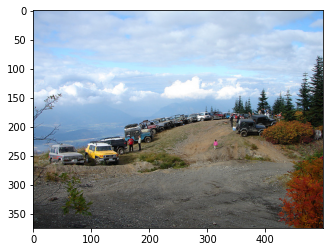

predicted caption : a backpacker is standing on a cliff towards a adults pole in the background
most similar caption : a line of off road vehicles is parked on the hill outside a wooded area 
similarity : 0.8020171


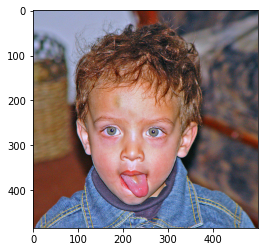

predicted caption : a young boy wearing a denim dress runs down a path
most similar caption : a young boy wearing a denim jacket sticks his tongue out 
similarity : 0.9118774


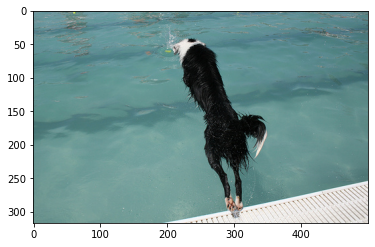

predicted caption : a dog runs through a field
most similar caption : a black dog jumping into a large pool 
similarity : 0.8600608


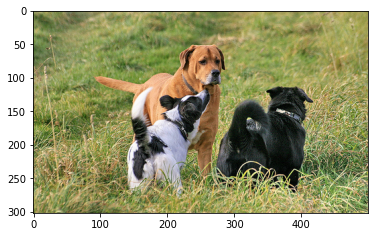

predicted caption : a black dog runs through a field
most similar caption : the three dogs are in a field 
similarity : 0.92927486


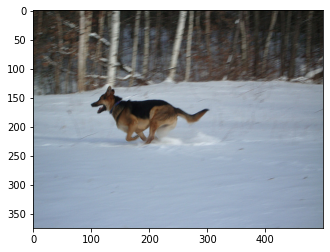

predicted caption : a black dog runs through a field
most similar caption : the dog runs through the snow 
similarity : 0.8744844


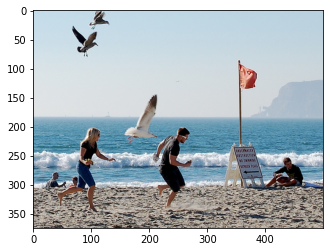

predicted caption : a young boy wearing a denim dress runs down a path
most similar caption : a couple of people running on the shore near the beach 
similarity : 0.84293467


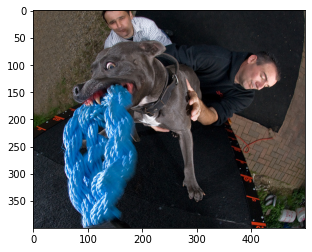

predicted caption : a black dog jumps into a pool that has many yellow balls in it
most similar caption : two men handle a grey dog with a blue knotted rope in its mouth 
similarity : 0.81038237


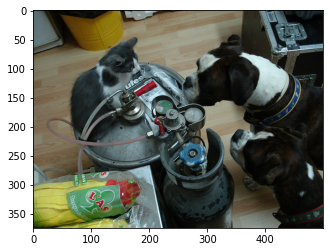

predicted caption : a brown dog walks along a beach wall
most similar caption : two dogs are staring at a grey and white cat 
similarity : 0.82304406


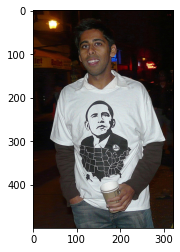

predicted caption : a man in a tank top standing on the sidewalk of the check of the check to another outside
most similar caption : a man wearing an obama t shirt and holding a coffee cup 
similarity : 0.6924542


In [34]:

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

pretrained_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",)
bert_model = AutoModel.from_pretrained("bert-base-uncased",output_hidden_states=True)


def get_embeddings(text,token_length):
    tokenized = pretrained_tokenizer(text,max_length=token_length,padding='max_length',truncation='longest_first')
    outputs = bert_model(torch.tensor(tokenized.input_ids).unsqueeze(0))
    sentence_embedding = torch.mean(outputs[0] ,dim = 0).detach().numpy()
    return sentence_embedding

def calculate_similarity(text1,text2,token_length=max_length):
    embedding1 = get_embeddings(text1,token_length).reshape(1,-1)
    embedding2 = get_embeddings(text2,token_length).reshape(1,-1)
    return cosine_similarity(embedding1,embedding2)[0][0]

def predict_caption(img_id):
    cap = 'start_char'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([cap])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')[0].reshape(1,max_length)
        output = model.predict([id_to_features[img_id][0].reshape(1,2048), seq], verbose=0)
        predict = np.argmax(output)
        word = tokenizer.index_word[predict]
        if word == 'end':
            cap = cap[len("start_char "):]
            break
        else:
            cap += ' ' + word
    return cap

def find_the_most_similar_caption(img_id,predicted_caption):
    max_similarity = 0
    most_similar_caption = ""
    for caption in id_to_captions[img_id]:
        caption = caption[len("start_char "):-len(" end_char")]
        similarity = calculate_similarity(predicted_caption,caption)
        if similarity > max_similarity:
            max_similarity = similarity
            most_similar_caption = caption
    return most_similar_caption , max_similarity


# get some random images

images = list(id_to_features.keys())
np.random.shuffle(images)
images = images[:10]

for img_id in images:
    image = load_img("images/Flicker8k_Dataset/" + img_id + ".jpg")
    plt.imshow(image)
    plt.show()
    predicted_caption = predict_caption(img_id)
    most_similar_caption , max_similarity = find_the_most_similar_caption(img_id,predicted_caption)
    print("predicted caption : " + predicted_caption)
    print("most similar caption : " + most_similar_caption)
    print("similarity : " + str(max_similarity))